In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
sys.path.append(os.getcwd() + "/../tests/hmm")
sys.path.append(os.getcwd() + "/../hepaccelerate")

In [2]:
from scipy.stats import wasserstein_distance

In [3]:
import copy

In [4]:
import hepaccelerate
import pars, plotting
from pars import cross_sections

from plotting import load_hist, make_pdf_plot, plot_hist_step, midpoints, histstep
plotting.plt = plt

In [5]:
shape_systematics = ["Total", "puWeight"]

In [6]:
mc_samples_combine_H = [
    "ggh",
    "vbf",
    "wmh",
    "wph",
    "zh",
    "tth",
    #"wz_1l1nu2q",
    "wz_3lnu",
    "ww_2l2nu", "wz_2l2q", "zz",
    #"ewk_lljj_mll50_mjj120",
    "ewk_lljj_mll105_160",
    #"st_top",
    #"st_t_antitop",
    "st_tw_top",
    "st_tw_antitop",
    "ttjets_sl", "ttjets_dl",
    "dy_m105_160_amc", "dy_m105_160_vbf_amc",
    "www","wwz","wzz","zzz",
]

mc_samples_combine_Z = [
    "ggh",
    "vbf",
    "wmh",
    "wph",
    "zh",
    "tth",
    #"wz_1l1nu2q",
    "wz_3lnu",
    "ww_2l2nu", "wz_2l2q", "zz",
    "ewk_lljj_mll50_mjj120",
    #"ewk_lljj_mll105_160",
    #"st_top",
    #"st_t_antitop",
    "st_tw_top",
    "st_tw_antitop",
    "ttjets_sl", "ttjets_dl",
    "dy_0j", "dy_1j", "dy_2j",
    "www","wwz","wzz","zzz",
]
mc_samples_load = list(set(mc_samples_combine_H + mc_samples_combine_Z))

In [7]:
dd = "../results/2019_08_13_v2/results/"
era = "2018"
res = {}
res["data"] = pickle.load(open(dd + "/data_{0}.pkl".format(era), "rb"))
for mc_samp in mc_samples_load:
    res[mc_samp] = pickle.load(open(dd + "/{0}_{1}.pkl".format(mc_samp, era), "rb"))

In [8]:
genweights = {}
weight_xs = {}
#in inverse picobarns
int_lumi = res["data"]["baseline"]["int_lumi"]
for mc_samp in mc_samples_load:
    genweights[mc_samp] = res[mc_samp]["genEventSumw"]
    weight_xs[mc_samp] = cross_sections[mc_samp] * int_lumi / genweights[mc_samp]

In [9]:
histnames = [h for h in res["data"]["baseline"].keys() if h.startswith("hist__")]

In [10]:
sorted(histnames)

['hist__dimuon__dijet_inv_mass',
 'hist__dimuon__leading_jet_eta',
 'hist__dimuon__leading_jet_pt',
 'hist__dimuon__leading_jet_qgl',
 'hist__dimuon__leading_muon_pt',
 'hist__dimuon__npvs',
 'hist__dimuon__num_jets',
 'hist__dimuon__num_soft_jets',
 'hist__dimuon__pt_balance',
 'hist__dimuon__subleading_jet_eta',
 'hist__dimuon__subleading_jet_pt',
 'hist__dimuon__subleading_jet_qgl',
 'hist__dimuon__subleading_muon_pt',
 'hist__dimuon_invmass_h_peak_cat5__Higgs_eta',
 'hist__dimuon_invmass_h_peak_cat5__Higgs_mass',
 'hist__dimuon_invmass_h_peak_cat5__Higgs_pt',
 'hist__dimuon_invmass_h_peak_cat5__MET_pt',
 'hist__dimuon_invmass_h_peak_cat5__M_jj',
 'hist__dimuon_invmass_h_peak_cat5__M_mmjj',
 'hist__dimuon_invmass_h_peak_cat5__Zep',
 'hist__dimuon_invmass_h_peak_cat5__bdt_ucsd',
 'hist__dimuon_invmass_h_peak_cat5__cthetaCS',
 'hist__dimuon_invmass_h_peak_cat5__dEta_jj',
 'hist__dimuon_invmass_h_peak_cat5__dEtamm',
 'hist__dimuon_invmass_h_peak_cat5__dPhimm',
 'hist__dimuon_invmass_h_

In [11]:
catnames = {
    "dimuon_invmass_z_peak_cat5": "dimuons, Z region, cat 5",
    "dimuon_invmass_h_peak_cat5": "dimuons, H SR, cat 5",
    "dimuon_invmass_h_sideband_cat5": "dimuons, H SB, cat 5",

    "dimuon_invmass_z_peak": "dimuons, Z region",
    "dimuon_invmass_h_peak": "dimuons, H SR",
    "dimuon_invmass_h_sideband": "dimuons, H SB",

    "dnn_presel": r"dimuons, $\geq 2$ jets",
    "dimuon": "dimuons",
}

varnames = {
    "subleadingJet_pt": "subleading jet $p_T$ [GeV]",
    "subleadingJet_eta": "subleading jet $\eta$",
    "leadingJet_pt": "leading jet $p_T$ [GeV]",
    "leadingJet_eta": "leading jet $\eta$",
    "pt_balance": "$p_T$ balance"
}

analysis_names = {
    "baseline": "JEC V16",
    "oldjec": "JEC V8"
}

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [98]:
def histstep(ax, edges, contents, **kwargs):
    ymins = []
    ymaxs = []
    xmins = []
    xmaxs = []
    for istep in range(len(edges)-1):
        xmins += [edges[istep]]
        xmaxs += [edges[istep+1]]
        ymins += [contents[istep]]
        if istep + 1 < len(contents):
            ymaxs += [contents[istep+1]]

    if kwargs.get("color", None) is None:
        kwargs["color"] = next(ax._get_lines.prop_cycler)['color']

    ymaxs += [ymaxs[-1]]
    l0 = ax.hlines(ymins, xmins, xmaxs, **kwargs)
    l1 = ax.vlines(xmaxs, ymins, ymaxs, color=l0.get_color(), linestyles=l0.get_linestyle())
    return l0

def assign_plot_title_label(histname):
    spl = histname.split("__")
    varname_nice = "UNKNOWN"
    catname_nice = "UNKNOWN"
    if len(spl) == 3:
        catname = spl[1]
        varname = spl[2]
        catname_nice = catnames[catname]
        if varname in varnames.keys():
            varname_nice = varnames[varname]
        else:
            varname_nice = varname
            print("WARNING: please define {0} in pars.py".format(varname))
            
    return varname_nice, catname_nice

def plot_hist_ratio(hists_mc, hist_data,
        total_err_stat=None,
        total_err_stat_syst=None,
        figure=None):
    
    if not figure:
        figure = plt.figure(figsize=(4,4), dpi=100)

    ax1 = plt.axes([0.0, 0.23, 1.0, 0.8])
       
    hmc_tot = np.zeros_like(hist_data.contents)
    hmc_tot2 = np.zeros_like(hist_data.contents)
    for h in hists_mc:
        plot_hist_step(ax1, h.edges, hmc_tot + h.contents,
            np.sqrt(hmc_tot2 + h.contents_w2),
            kwargs_step={"label": getattr(h, "label", None), "color": getattr(h, "color", None)}
        )
        
        b = ax1.bar(midpoints(h.edges), h.contents, np.diff(h.edges), hmc_tot, color=getattr(h, "color", None))
        hmc_tot += h.contents
        hmc_tot2 += h.contents_w2

#    plot_hist_step(h["edges"], hmc_tot, np.sqrt(hmc_tot2), kwargs_step={"color": "gray", "label": None})
    ax1.errorbar(
        midpoints(hist_data.edges), hist_data.contents,
        np.sqrt(hist_data.contents_w2), marker="o", lw=0,
        elinewidth=1.0, color="black", ms=3, label=getattr(hist_data, "label", None))
    
    if not (total_err_stat_syst is None):
        histstep(ax1, hist_data.edges, hmc_tot + total_err_stat_syst, color="blue", linewidth=0.5, linestyle="--", label="stat+syst")
        histstep(ax1, hist_data.edges, hmc_tot - total_err_stat_syst, color="blue", linewidth=0.5, linestyle="--")
    
    if not (total_err_stat is None):
        histstep(ax1, hist_data.edges, hmc_tot + total_err_stat, color="gray", linewidth=0.5, linestyle="--", label="stat")
        histstep(ax1, hist_data.edges, hmc_tot - total_err_stat, color="gray", linewidth=0.5, linestyle="--")
        
#     ax1.set_yscale("log")
#     ax1.set_ylim(1e-2, 100*np.max(hist_data.contents))
    
    #ax1.get_yticklabels()[-1].remove()
    
    ax2 = plt.axes([0.0, 0.0, 1.0, 0.16], sharex=ax1)

    ratio = hist_data.contents / hmc_tot
    ratio_err = np.sqrt(hist_data.contents_w2) /hmc_tot
    ratio[np.isnan(ratio)] = 0

    plt.errorbar(midpoints(hist_data.edges), ratio, ratio_err, marker="o", lw=0, elinewidth=1, ms=3, color="black")

    if not (total_err_stat_syst is None):
        ratio_up = (hmc_tot + total_err_stat_syst) / hmc_tot
        ratio_down = (hmc_tot - total_err_stat_syst) / hmc_tot
        ratio_down[np.isnan(ratio_down)] = 1
        ratio_down[np.isnan(ratio_up)] = 1
        histstep(ax2, hist_data.edges, ratio_up, color="blue", linewidth=0.5, linestyle="--")
        histstep(ax2, hist_data.edges, ratio_down, color="blue", linewidth=0.5, linestyle="--")

    if not (total_err_stat is None):
        ratio_up = (hmc_tot + total_err_stat) / hmc_tot
        ratio_down = (hmc_tot - total_err_stat) / hmc_tot
        ratio_down[np.isnan(ratio_down)] = 1
        ratio_down[np.isnan(ratio_up)] = 1
        histstep(ax2, hist_data.edges, ratio_up, color="gray", linewidth=0.5, linestyle="--")
        histstep(ax2, hist_data.edges, ratio_down, color="gray", linewidth=0.5, linestyle="--")

                
    plt.ylim(0.5, 1.5)
    plt.axhline(1.0, color="black")
    
    return ax1, ax2

def make_pdf_plot(args, **kwargs):
    res, hd, mc_samples, analysis, var, weight, weight_xs, int_lumi, outdir, datataking_year, groups = args

    hist_template = copy.deepcopy(hd)
    hist_template.contents[:] = 0
    hist_template.contents_w2[:] = 0

    hmc = {}

    for mc_samp in mc_samples:
        h = res[mc_samp][weight]
        h = h * weight_xs[mc_samp]
        h.label = "{0} ({1:.1E})".format(mc_samp, np.sum(h.contents))
        hmc[mc_samp] = h
    
    hmc_g = group_samples(hmc, groups)

    for k, v in hmc_g.items():
        if k in colors.keys():
            v.color = colors[k][0]/255.0, colors[k][1]/255.0, colors[k][2]/255.0
    hmc = [hmc_g[k[0]] for k in groups]

        
    htot_nominal = sum(hmc, hist_template)
    htot_variated = {}
    hdelta_quadrature = np.zeros_like(hist_template.contents)
    
    for sdir in ["__up", "__down"]:
        for unc in shape_systematics:
            if (unc + sdir) in res[mc_samp]:
                htot_variated[unc + sdir] = sum([
                    res[mc_samp][unc + sdir]* weight_xs[mc_samp] for mc_samp in mc_samples
                ], hist_template)
                hdelta_quadrature += (htot_nominal.contents - htot_variated[unc+sdir].contents)**2
            
    hdelta_quadrature_stat = np.sqrt(htot_nominal.contents_w2)
    hdelta_quadrature_stat_syst = np.sqrt(hdelta_quadrature_stat**2 + hdelta_quadrature)
    hd.label = "data ({0:.1E})".format(np.sum(hd.contents))

    figure = plt.figure(figsize=(5,5), dpi=100)
    a1, a2 = plot_hist_ratio(hmc, hd,
        total_err_stat=hdelta_quadrature_stat, total_err_stat_syst=hdelta_quadrature_stat_syst, figure=figure)
    
    colorlist = [h.color for h in hmc]
    a1inset = inset_axes(a1, width=1.0, height=0.1, loc=2)
    pct_barh(a1inset, [np.sum(h.contents) for h in hmc], colorlist)
    #a2.grid(which="both", linewidth=0.5)
    
    # Ratio axis ticks
    #ts = a2.set_yticks([0.5, 1.0, 1.5], minor=False)
    #ts = a2.set_yticks(np.arange(0,2,0.2), minor=True)
    #ts = a2.set_xticklabels([])

    #a2.set_yticks(np.linspace(0.5,1.5, ))
    if var.startswith("hist_numjet"):
        a1.set_xticks(hd["edges"])

    a1.text(0.03,0.95, "CMS internal\n" +
        r"$L = {0:.1f}\ fb^{{-1}}$".format(int_lumi/1000.0) + 
        "\nd/mc={0:.2f}".format(np.sum(hd.contents)/np.sum(htot_nominal.contents)) + 
        "\nwd={0:.2E}".format(wasserstein_distance(htot_nominal.contents/np.sum(htot_nominal.contents), hd.contents/np.sum(hd.contents))),
        horizontalalignment='left',
        verticalalignment='top',
        transform=a1.transAxes,
        fontsize=10
    )
    handles, labels = a1.get_legend_handles_labels()
    a1.legend(handles[::-1], labels[::-1], frameon=False, fontsize=10, loc=1, ncol=2)
    
    varname, catname = assign_plot_title_label(var)
    
    a1.set_title(catname + " ({0})".format(analysis_names[analysis]))
    a2.set_xlabel(varname)
    
    binwidth = np.diff(hd.edges)[0]
    a1.set_ylabel("events / bin [{0:.1f}]".format(binwidth))
    try:
        os.makedirs(outdir + "/png")
    except Exception as e:
        pass
    try:
        os.makedirs(outdir + "/pdf")
    except Exception as e:
        pass
    #plt.savefig(outdir + "/pdf/{0}_{1}_{2}.pdf".format(analysis, var, weight), bbox_inches="tight")
    #plt.savefig(outdir + "/png/{0}_{1}_{2}.png".format(analysis, var, weight), bbox_inches="tight", dpi=100)
    #plt.close(figure)
    #del figure
 
    return a1, a2

In [99]:
def pct_barh(ax, values, colors):
    prev = 0
    norm = sum(values)
    for v, c in zip(values, colors):
        ax.barh(0, width=v/norm, height=1.0, left=prev, color=c)
        prev += v/norm
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0,prev)
    ax.axis('off')

In [100]:
def group_samples(histos, groups):
    ret = {}
    for groupname, groupcontents in groups:
        ret[groupname] = []
        for gc in groupcontents:
            if gc in histos:
                ret[groupname] += [histos[gc]]
        assert(len(ret[groupname]) > 0)
        ret[groupname] = sum(ret[groupname][1:], ret[groupname][0])
        ret[groupname].label = "{0} ({1:.2E})".format(groupname, np.sum(ret[groupname].contents))
    return ret

In [101]:
groups = [
    ("higgs", ["ggh", "vbf", "wmh", "wph", "zh", "tth"]),
    ("vv", ["wz_3lnu", "ww_2l2nu", "wz_2l2q", "zz"]),
    ("vvv", ["www","wwz","wzz","zzz"]),
    ("ewk", ["ewk_lljj_mll50_mjj120", "ewk_lljj_mll105_160"]),
    ("stop", ["st_tw_top", "st_tw_antitop"]),
    ("tt", ["ttjets_sl", "ttjets_dl",]),
    ("dy", ["dy_0j", "dy_1j", "dy_2j", "dy_m105_160_amc", "dy_m105_160_vbf_amc"]),
]

In [102]:
colors = {
    "dy": (254, 254, 83),
    "ewk": (109, 253, 245),
    "stop": (236, 76, 105),
    "tt": (67, 150, 42),
    "vvv": (247, 206, 205),
    "vv": (100, 105, 98),
    "higgs": (0, 0, 0),
}

In [105]:
def plot_analysis_var(analysis, var, mc_samples, **kwargs):
    histos = {s: copy.deepcopy(res[s][analysis][var]) for s in mc_samples + ["data"]}
    hdata = copy.deepcopy(histos["data"]["nominal"])
    
    if "edges" in kwargs:
        for k, hs in histos.items():
            for syst, h in hs.items():
                h.edges = kwargs.get("edges")
        hdata.edges = kwargs.get("edges")
        
    args = [(
        histos, hdata, mc_samples, analysis,
        var, "nominal", weight_xs, int_lumi, "./", era, groups)]
    a1, a2 = make_pdf_plot(*args)
    return a1, a2


/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


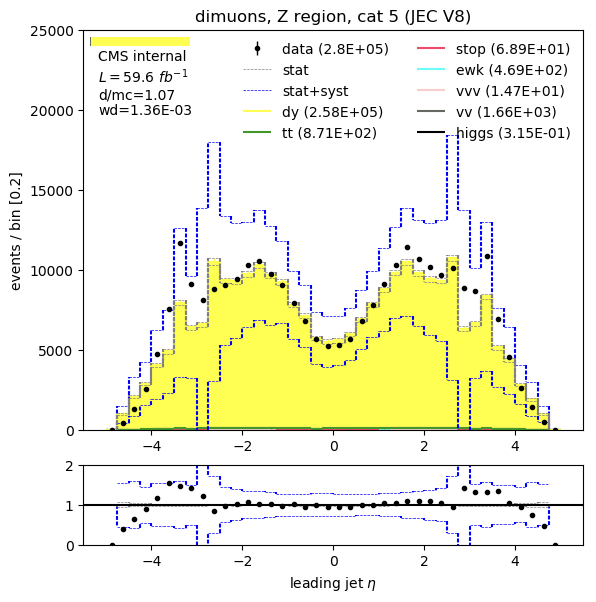

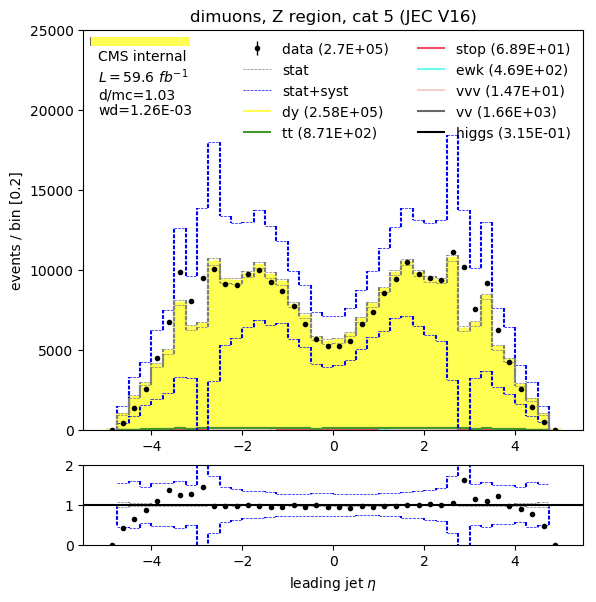

In [106]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__leadingJet_eta", mc_samples_combine_Z)
    a1.set_yscale("linear")
    a1.set_ylim(0,25000)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


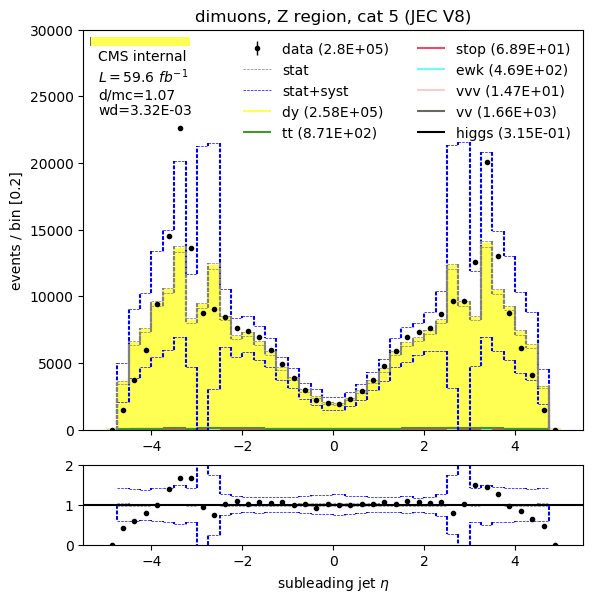

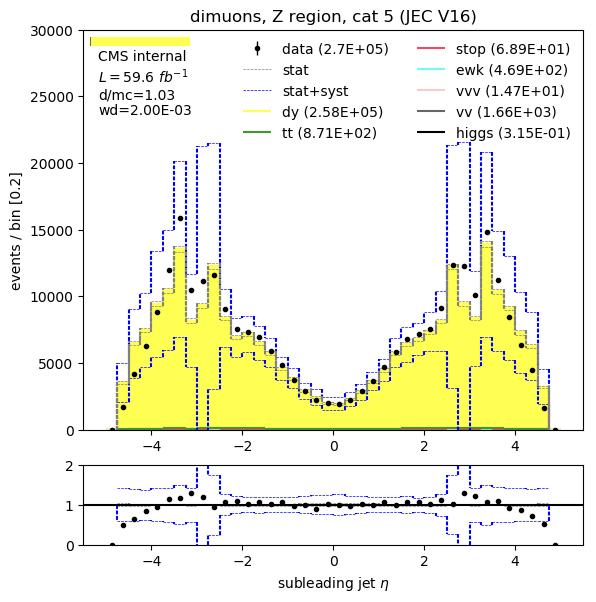

In [107]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__subleadingJet_eta", mc_samples_combine_Z)
    a1.set_yscale("linear")
    a1.set_ylim(0,30000)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


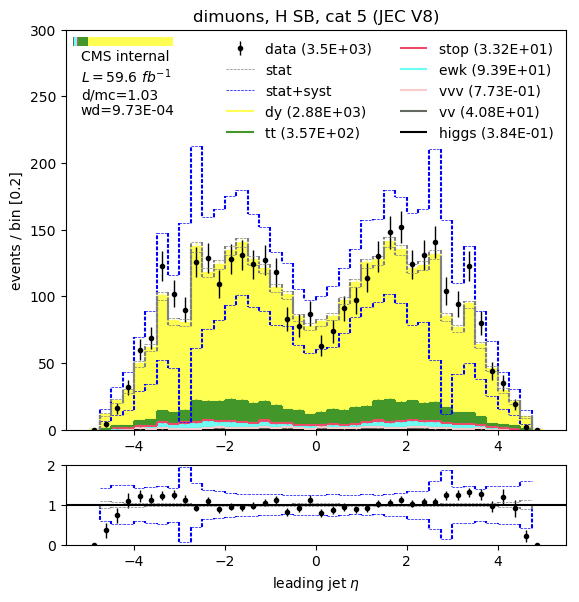

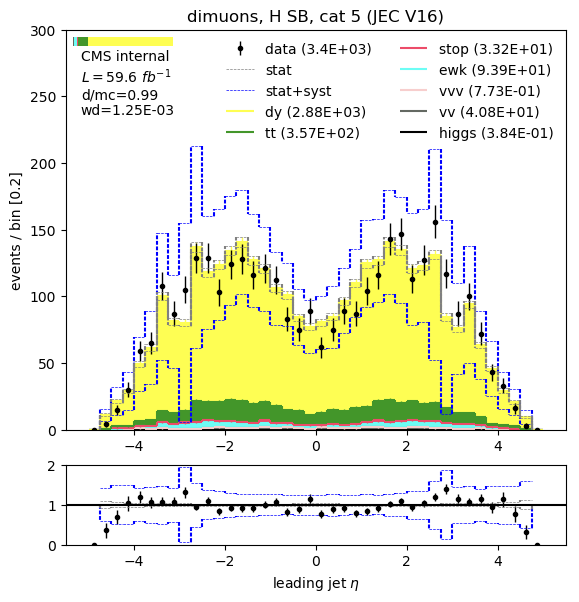

In [108]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__leadingJet_eta", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,300)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


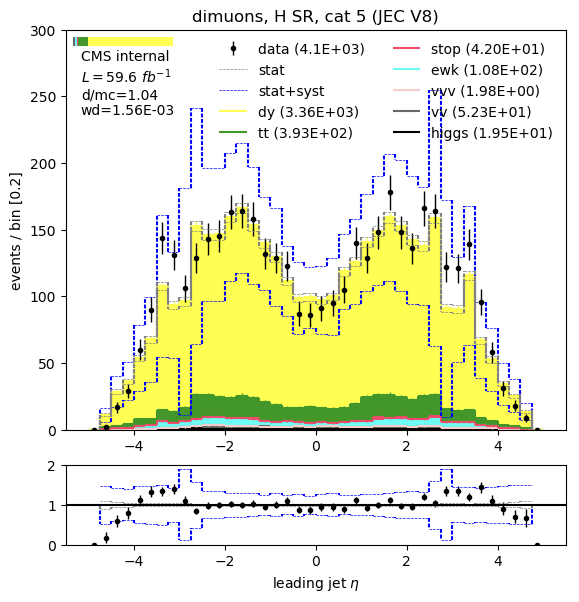

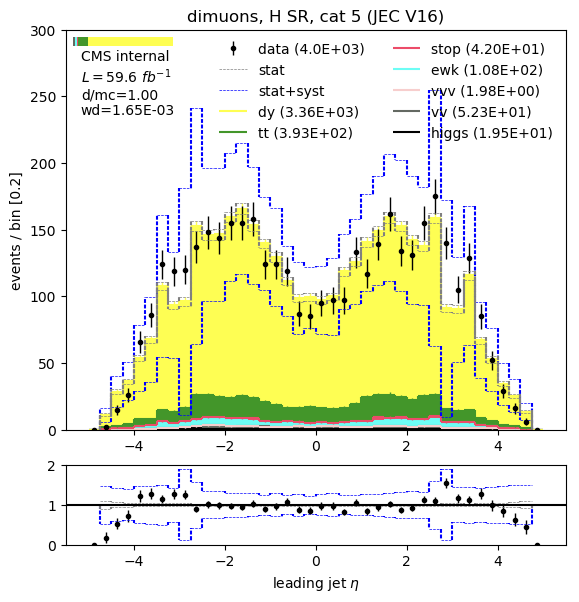

In [109]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_peak_cat5__leadingJet_eta", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,300)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


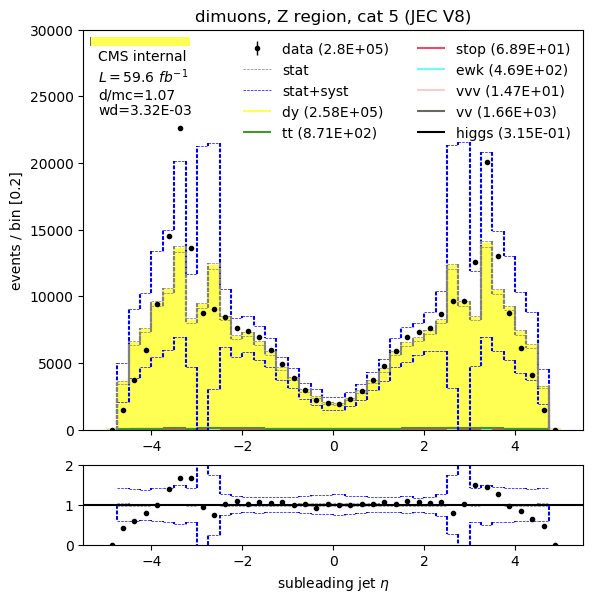

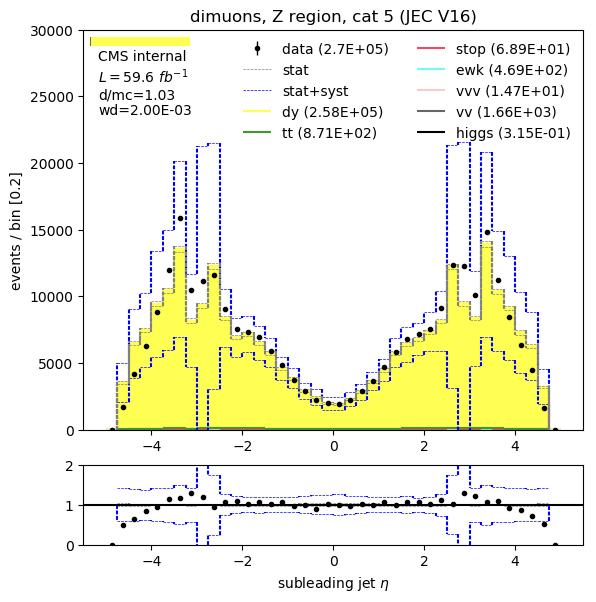

In [110]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__subleadingJet_eta", mc_samples_combine_Z)
    a1.set_yscale("linear")
    a1.set_ylim(0,30000)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


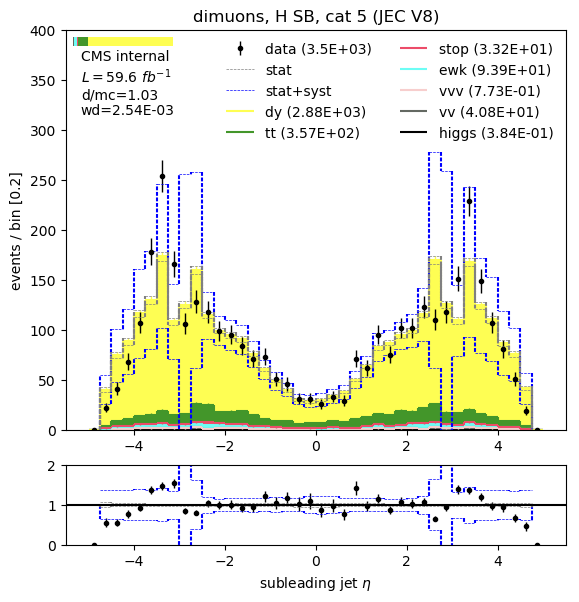

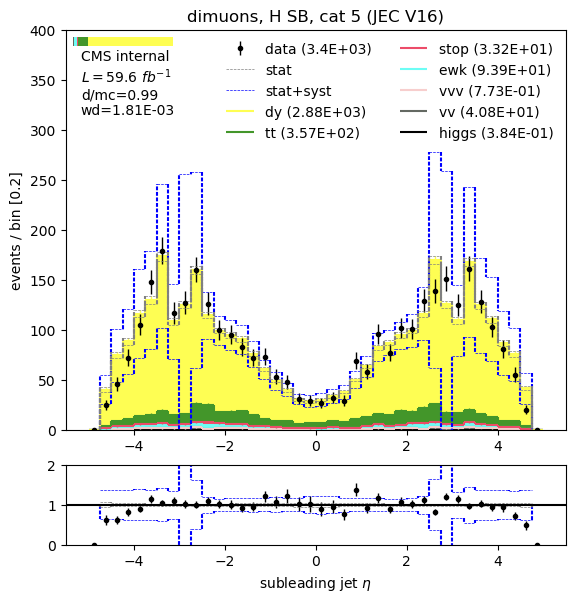

In [24]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__subleadingJet_eta", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,400)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


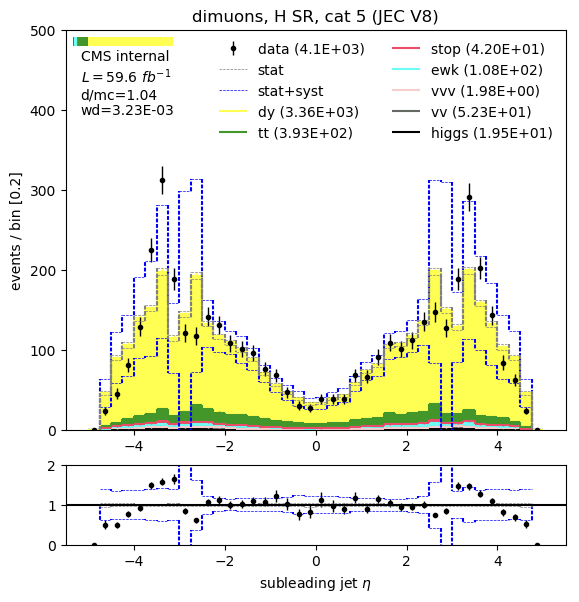

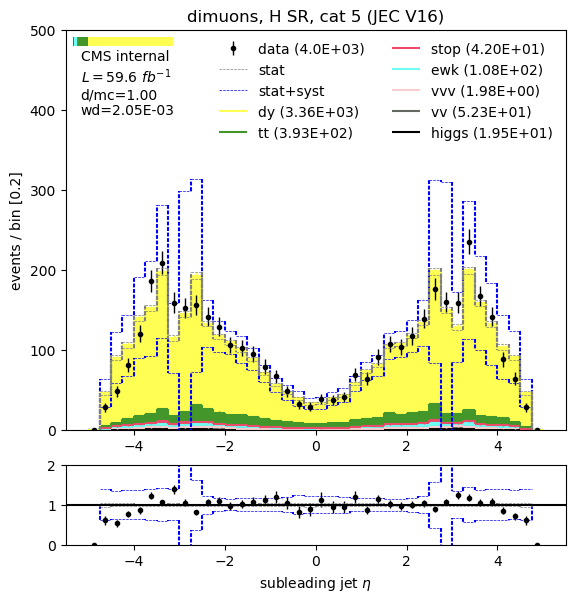

In [25]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_peak_cat5__subleadingJet_eta", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,500)
    a2.set_ylim(0,2)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


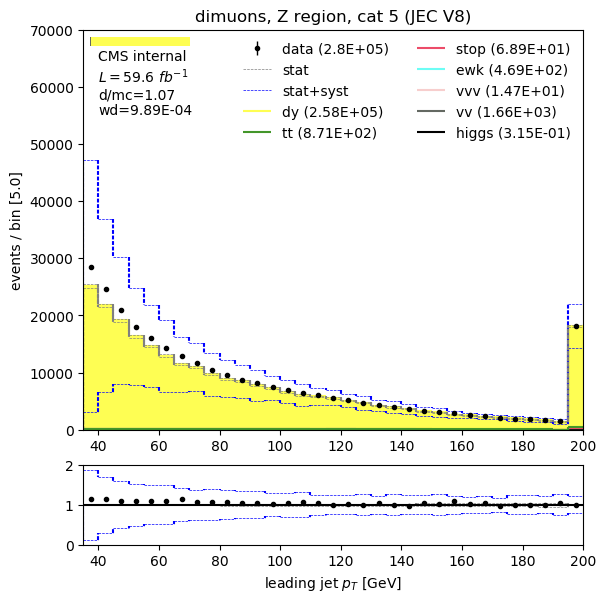

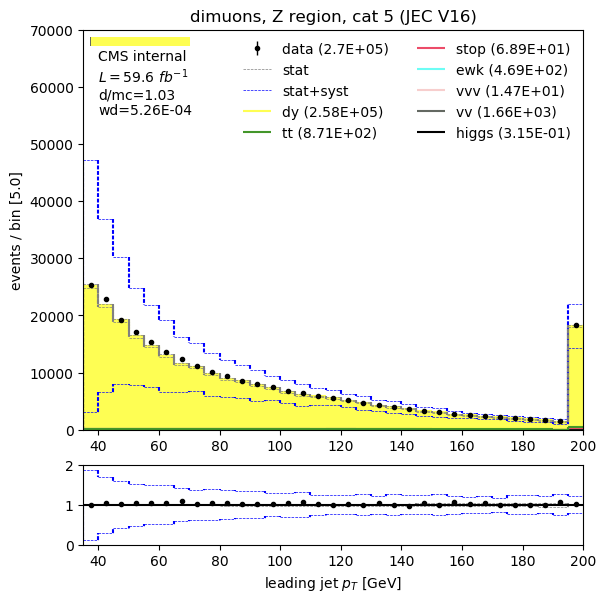

In [26]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__leadingJet_pt", mc_samples_combine_Z)
    a1.set_yscale("linear")
    a1.set_ylim(0,70000)
    a2.set_ylim(0,2)
    a2.set_xlim(35,200)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


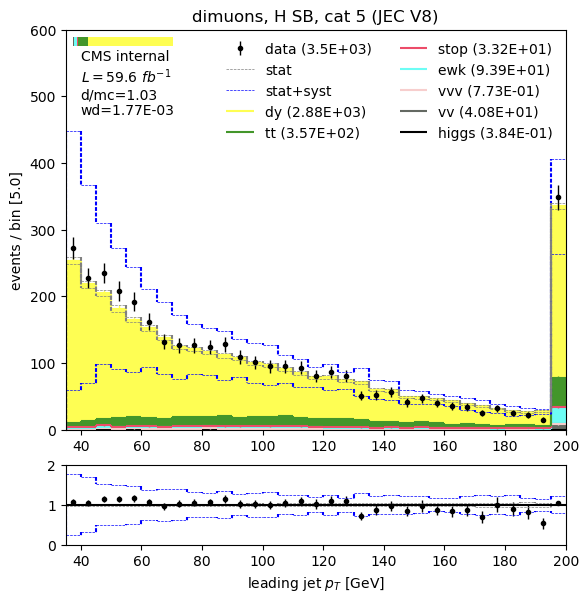

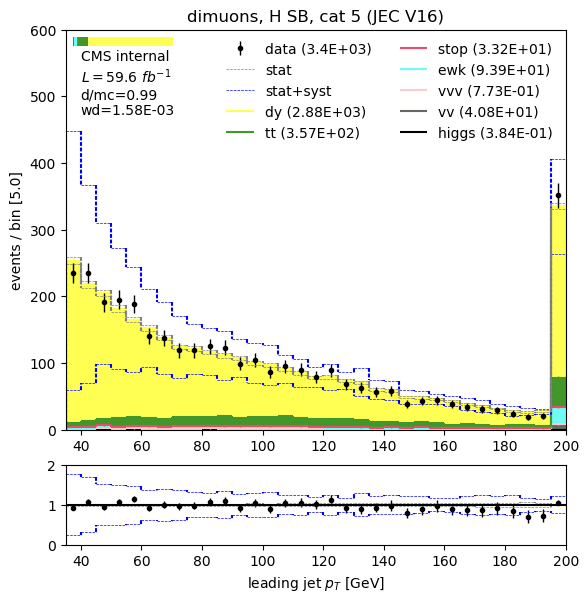

In [27]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__leadingJet_pt", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,600)
    a2.set_ylim(0,2)
    a2.set_xlim(35,200)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


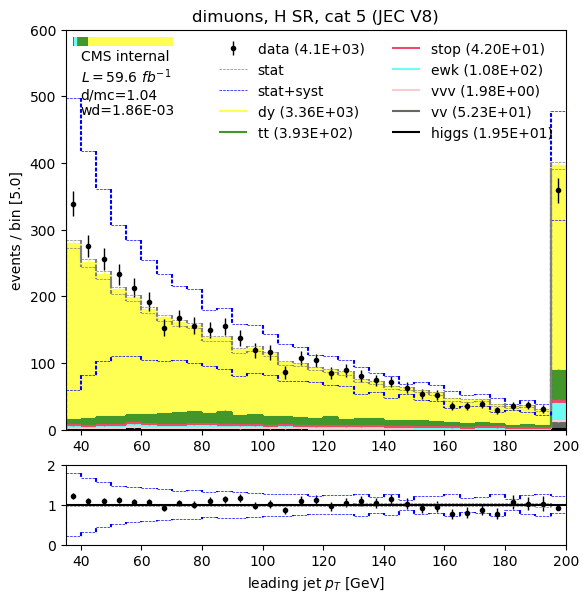

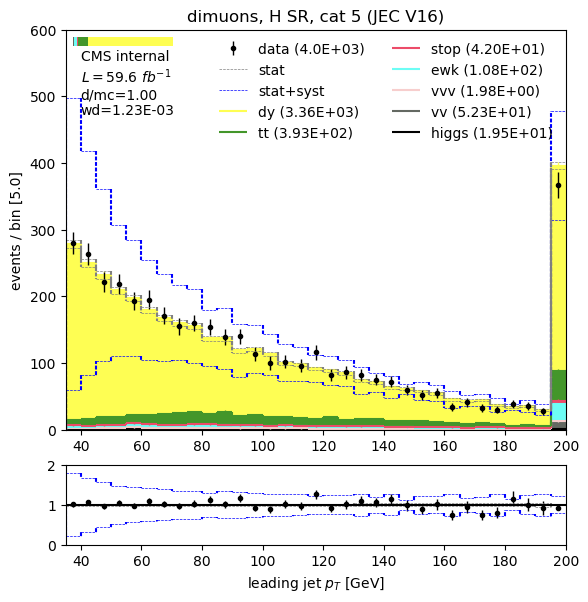

In [28]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_peak_cat5__leadingJet_pt", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,600)
    a2.set_ylim(0,2)
    a2.set_xlim(35,200)

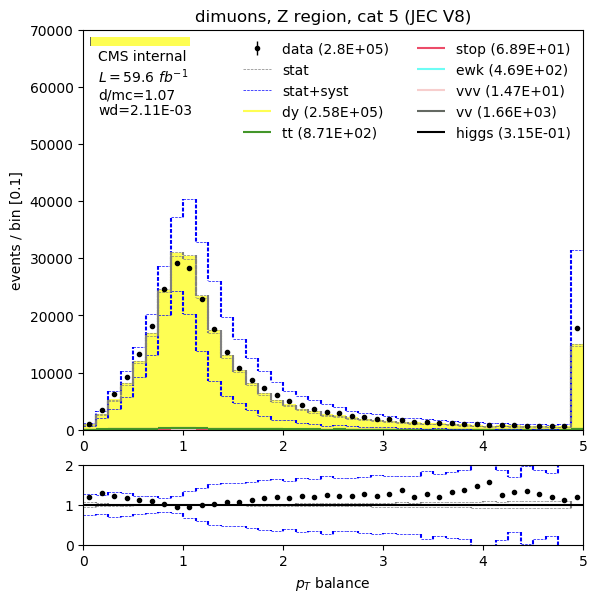

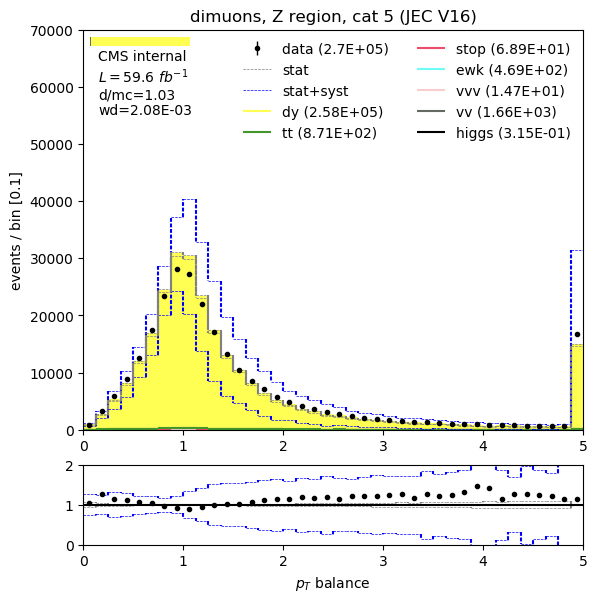

In [29]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__pt_balance", mc_samples_combine_Z)
    a1.set_yscale("linear")
    a1.set_ylim(0,70000)
    a2.set_ylim(0,2)
    a2.set_xlim(0,5)

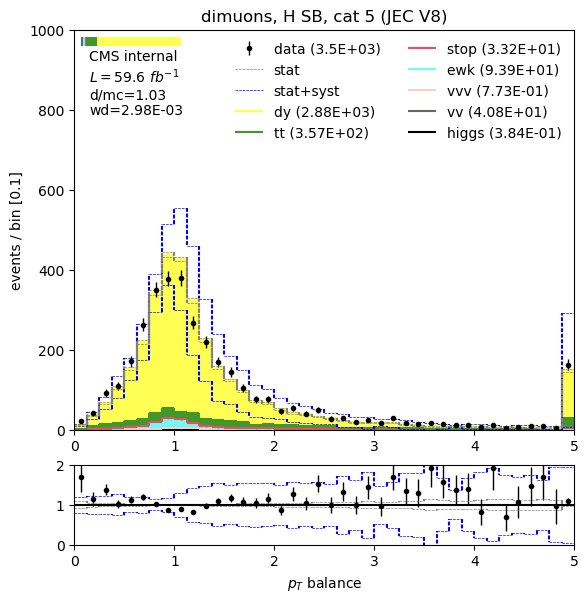

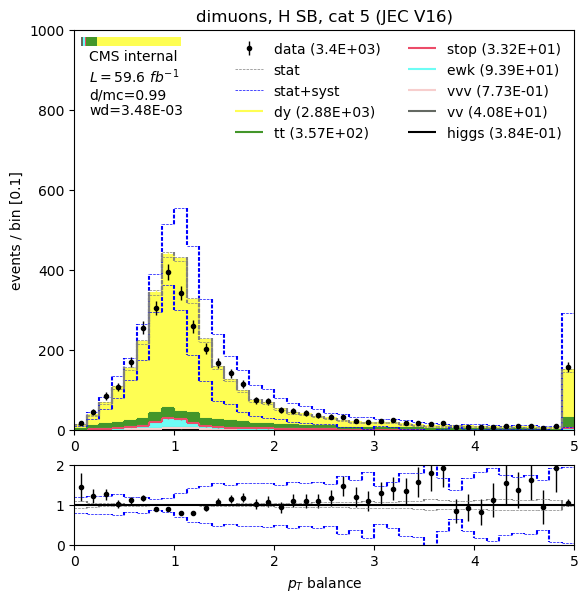

In [30]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__pt_balance", mc_samples_combine_H)
    a1.set_yscale("linear")
    a1.set_ylim(0,1000)
    a2.set_ylim(0,2)
    a2.set_xlim(0,5)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


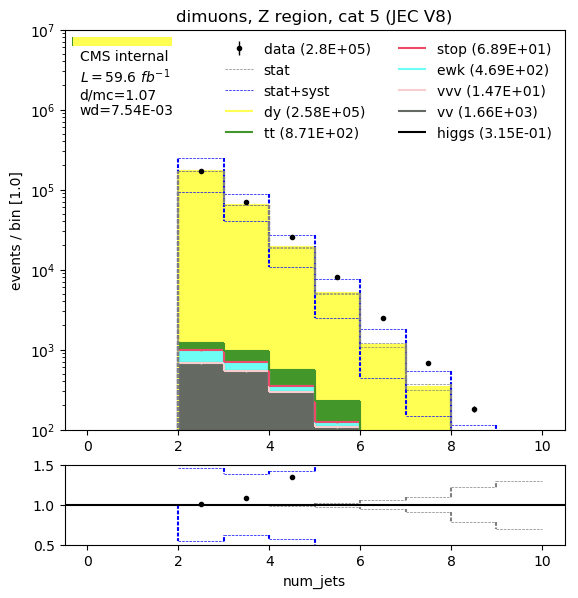

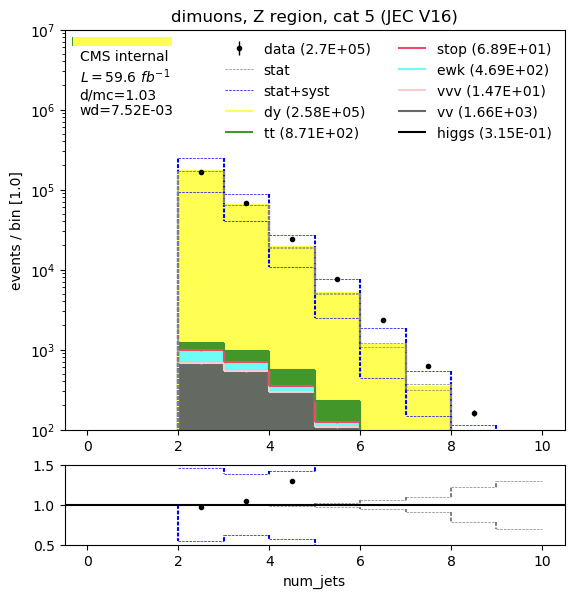

In [31]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__num_jets", mc_samples_combine_Z)
    a1.set_yscale("log")
    a1.set_ylim(100,1e7)

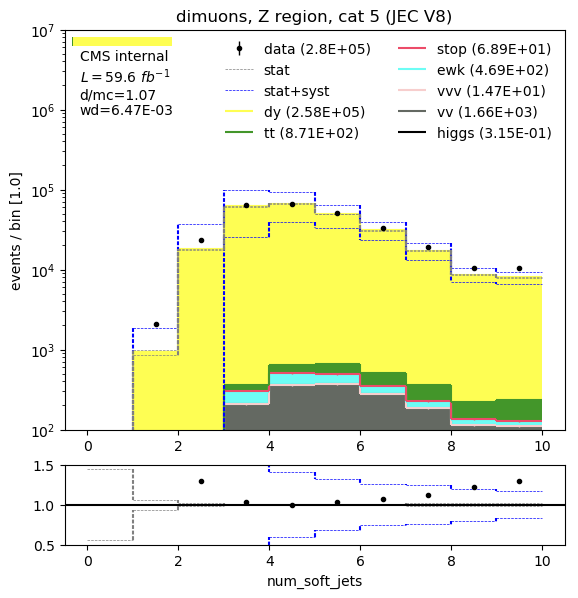

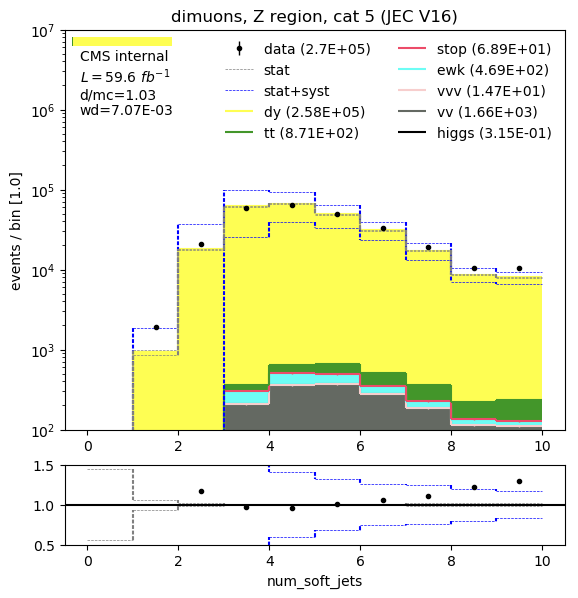

In [32]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__num_soft_jets", mc_samples_combine_Z)
    a1.set_yscale("log")
    a1.set_ylim(100,1e7)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


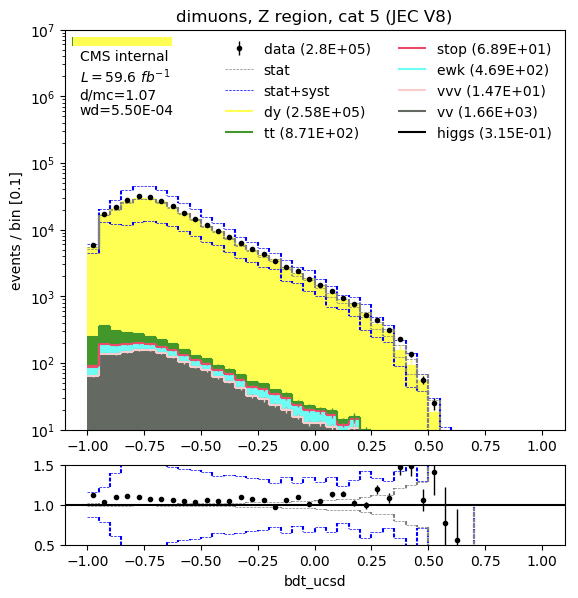

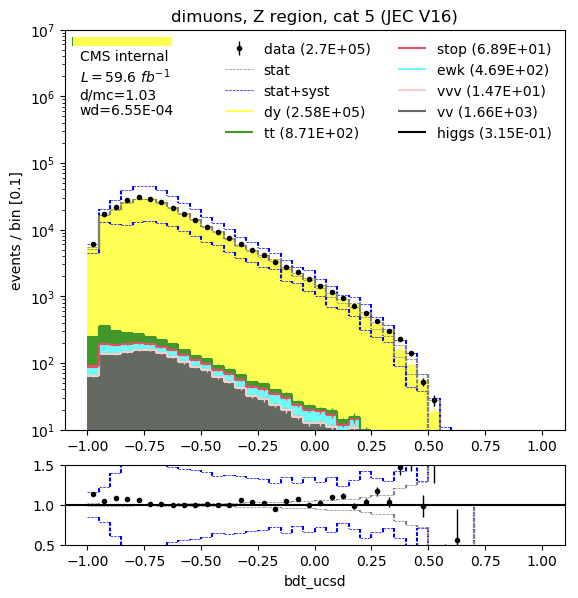

In [33]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__bdt_ucsd", mc_samples_combine_Z)
    a1.set_yscale("log")
    a1.set_ylim(10,1e7)

/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/Users/joosep/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


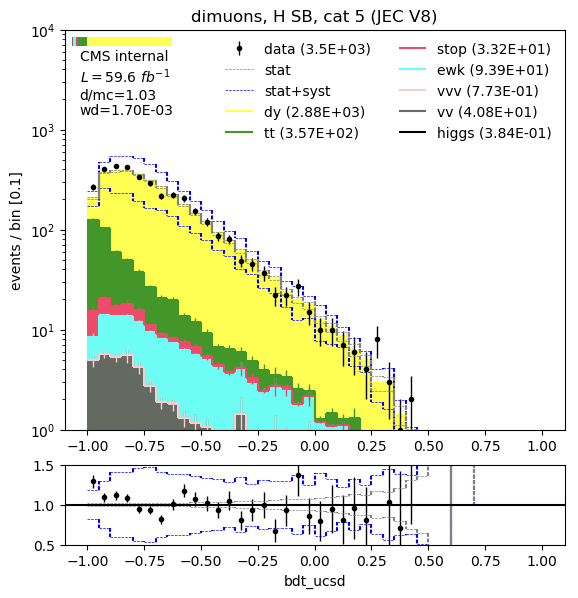

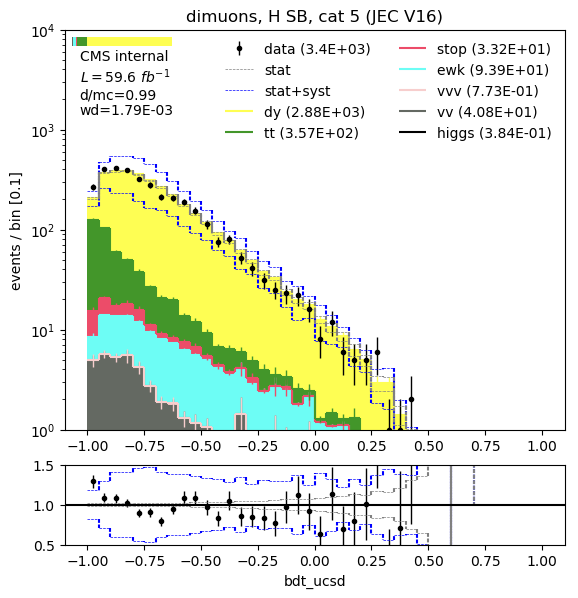

In [34]:
for analysis in ["oldjec", "baseline"]:
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__bdt_ucsd", mc_samples_combine_H)
    a1.set_yscale("log")
    a1.set_ylim(1,1e4)

[0.  0.1 0.2 0.3 0.4 0.5 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 1. ]


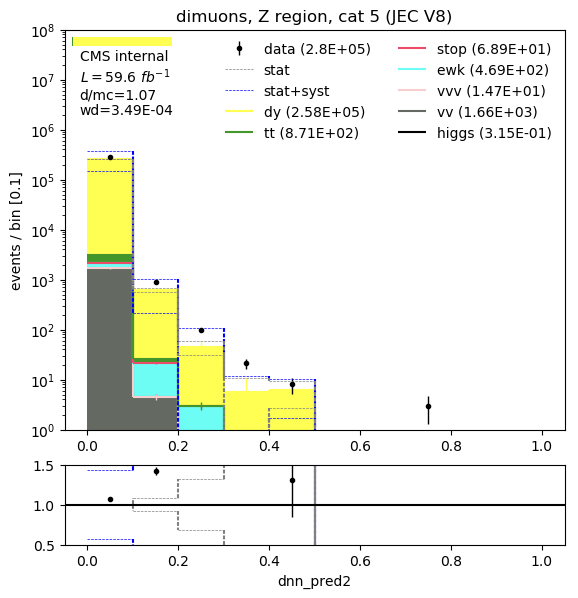

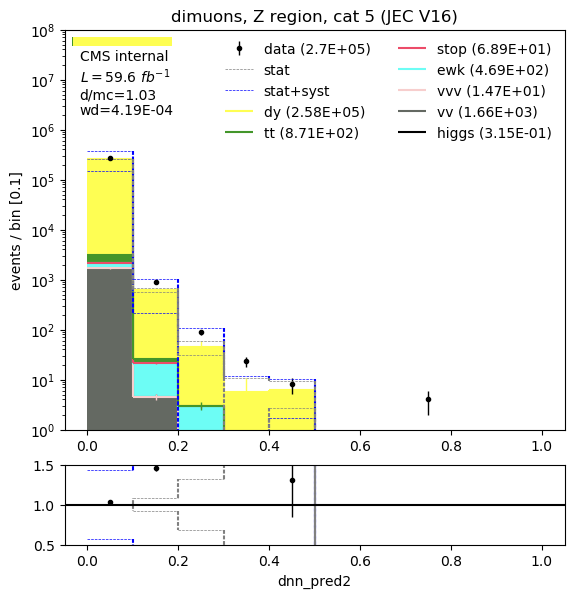

In [38]:
for analysis in ["oldjec", "baseline"]:
    xs_edges = res["data"][analysis]["hist__dimuon_invmass_z_peak_cat5__dnn_pred2"]["nominal"].edges
    xs = np.arange(len(xs_edges))
    print(xs_edges)
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_z_peak_cat5__dnn_pred2", mc_samples_combine_Z)
    a1.set_yscale("log")
    a1.set_ylim(1,1e8)
    #a1.set_xticks(xs)
    #a1.set_xticklabels(map(str, xs_edges))

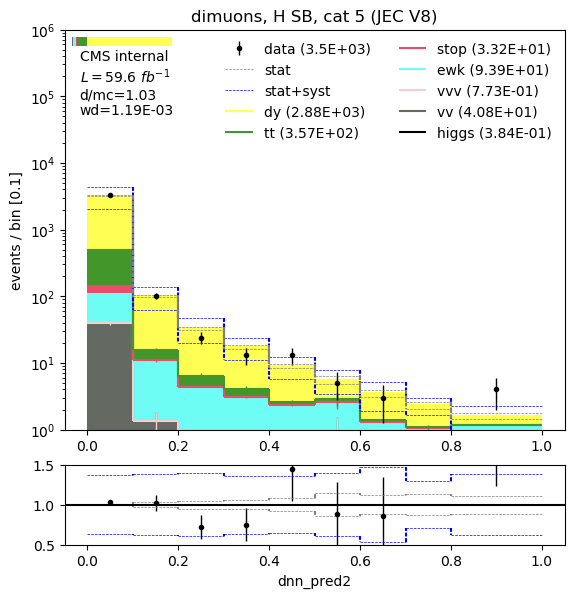

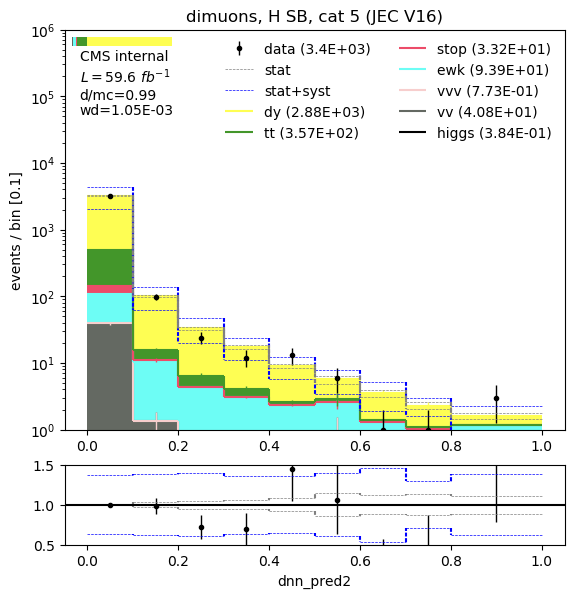

In [36]:
for analysis in ["oldjec", "baseline"]:
    #xs_edges = res["data"][analysis]["hist__dimuon_invmass_h_sideband_cat5__dnn_pred2"]["nominal"].edges
    #xs = np.arange(len(xs_edges))
    #print(xs_edges)
    a1, a2 = plot_analysis_var(analysis, "hist__dimuon_invmass_h_sideband_cat5__dnn_pred2", mc_samples_combine_H)
    a1.set_yscale("log")
    a1.set_ylim(1,1e6)
    #a1.set_xticks(xs)
    #a1.set_xticklabels(map(str, xs_edges))